In [ ]:
!pip install pytorch-tabnet

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import time
import datetime
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("/content/drive/My Drive/zindi/Train.csv")
test = pd.read_csv("/content/drive/My Drive/zindi/Test.csv")

In [ ]:
#Попробовать с новыми фичами, должно быть хорошо
index = train.sample(500000, random_state=42).index

X_train, X_testval, y_train, y_testval = train_test_split(train.iloc[index], y.iloc[index], test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.33)

del X_testval, y_testval

In [ ]:

clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=4e-2),
                       scheduler_params={"step_size": 5,
                                         "gamma": 0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax'
)

Device used : cuda


In [ ]:
clf.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_val.values, y_val.values)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=1000, patience=15,
    batch_size=131072, virtual_batch_size=16384,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 0.32643 | train_auc: 0.92982 | valid_auc: 0.93035 |  0:00:19s
epoch 1  | loss: 0.32509 | train_auc: 0.92981 | valid_auc: 0.93024 |  0:00:39s
epoch 2  | loss: 0.32374 | train_auc: 0.93    | valid_auc: 0.9306  |  0:00:59s
epoch 3  | loss: 0.32062 | train_auc: 0.93009 | valid_auc: 0.93075 |  0:01:18s
epoch 4  | loss: 0.3216  | train_auc: 0.93021 | valid_auc: 0.93073 |  0:01:38s
epoch 5  | loss: 0.32147 | train_auc: 0.93029 | valid_auc: 0.93075 |  0:01:57s
epoch 6  | loss: 0.32109 | train_auc: 0.93032 | valid_auc: 0.93081 |  0:02:17s
epoch 7  | loss: 0.32024 | train_auc: 0.93034 | valid_auc: 0.93084 |  0:02:36s
epoch 8  | loss: 0.3184  | train_auc: 0.93035 | valid_auc: 0.93083 |  0:02:56s
epoch 9  | loss: 0.32141 | train_auc: 0.93036 | valid_auc: 0.93084 |  0:03:16s
epoch 10 | loss: 0.32107 | train_auc: 0.93047 | valid_auc: 0.93088 |  0:03:35s
epoch 11 | loss: 0.3186  | train_auc: 0.93049 | valid_auc: 0.93086 |  0:03:55s
epoch 12 | loss: 0.31931 | train_auc: 0.9305  | vali

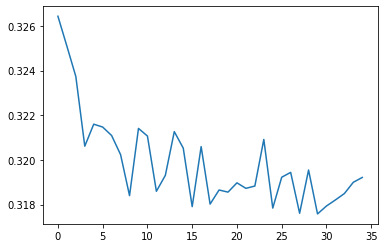

In [ ]:
plt.plot(clf.history['loss'])

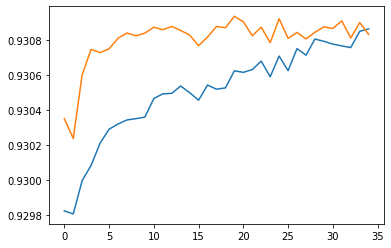

In [ ]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

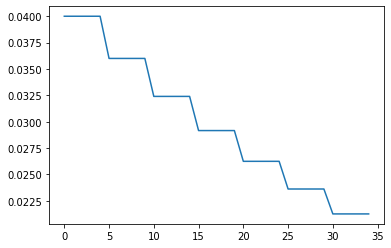

In [ ]:
plt.plot(clf.history['lr'])

In [ ]:
preds = clf.predict_proba(X_test.values)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

preds_val = clf.predict_proba(X_val.values)
val_auc = roc_auc_score(y_score=preds_val[:,1], y_true=y_val)

print(f"BEST VAL SCORE: {val_auc}")
print(f"FINAL TEST SCORE: {test_auc}")

BEST VAL SCORE: 0.9309383333430148
FINAL TEST SCORE: 0.9326998941203849


In [ ]:
final_preds = clf.predict_proba(test.values)

In [ ]:
submission = pd.read_csv('/content/drive/My Drive/zindi/SampleSubmission.csv')
submission["CHURN"] = final_preds[:, 1]
submission.to_csv('tabnet_500k.csv', index=False)
files.download("tabnet_500k.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>